In [1]:
import numpy as np
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import get_critical_contacts
from src.gmm import *
from src.contact_space import *
from Bio import SeqIO
from scipy import stats

In [2]:
def generate_orthogonal_vectors(v_target, num_vectors=3, random_state=42):
    """
    生成与目标向量正交的向量
    
    Args:
        v_target: 目标向量 (244,)
        num_vectors: 需要生成的正交向量数量
        random_state: 随机种子
    
    Returns:
        orthogonal_vectors: 正交向量列表，每个向量都与v_target正交
    """
    np.random.seed(random_state)
    
    # 标准化目标向量
    v_target_norm = v_target / np.linalg.norm(v_target)
    
    orthogonal_vectors = []
    
    for i in range(num_vectors):
        # 生成随机向量
        random_vec = np.random.randn(len(v_target))
        
        # 从随机向量中减去在v_target上的投影，使其正交
        projection = np.dot(random_vec, v_target_norm) * v_target_norm
        orthogonal_vec = random_vec - projection
        
        # 对已有的正交向量进行正交化（Gram-Schmidt过程）
        for existing_vec in orthogonal_vectors:
            projection = np.dot(orthogonal_vec, existing_vec) * existing_vec
            orthogonal_vec -= projection
        
        # 标准化
        orthogonal_vec = orthogonal_vec / np.linalg.norm(orthogonal_vec)
        orthogonal_vectors.append(orthogonal_vec)
    
    return orthogonal_vectors


In [3]:
def generate_single_mutants(seq):
    """生成单点突变体"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    mutants = []
    
    for i, aa in enumerate(seq):
        for new_aa in amino_acids:
            if new_aa != aa:
                mutant = seq[:i] + new_aa + seq[i+1:]
                mutants.append(mutant)
    
    return mutants


def embed_and_project_mutants(mutants: List[str], 
                                     target_contacts: List[Tuple[int, int]],
                                     mj_dict: Dict,
                                     scaler: StandardScaler, # 传入训练好的scaler
                                     v_target: np.ndarray,
                                     v_control: np.ndarray,
                                     origin_point: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    d = len(target_contacts)
    m = len(mutants)
    x_raw = np.zeros((m, d)) # (m, d) 的二维数组，m是序列数量

    # 1. 构建原始embedding矩阵 (处理多个序列)
    for seq_idx, sequence in enumerate(mutants):
        for contact_idx, (i, j) in enumerate(target_contacts):
            if i < len(sequence) and j < len(sequence):
                res_i, res_j = sequence[i], sequence[j]
                if res_i != '-' and res_j != '-':
                    mj_energy = mj_dict.get((res_i.upper(), res_j.upper()), 0)
                    x_raw[seq_idx, contact_idx] = mj_energy

    # 2. 使用"已训练"的scaler进行标准化 (最关键的一步)
    # 这里用 .transform() 而不是 .fit_transform()!
    # 这保证了新序列是在旧坐标系下进行标准化
    x_scaled = scaler.transform(x_raw)

    # 3. 计算相对位移的投影
    # origin_point 是我们关心的起点，比如Anc.2最优序列的坐标
    displacement_vectors = x_scaled - origin_point  # 广播，每行都减去origin_point
    
    projection_target = np.dot(displacement_vectors, v_target)  # (m,) 向量
    projection_control = np.dot(displacement_vectors, v_control)  # (m,) 向量
    
    return projection_target, projection_control






In [4]:
def analyze_mutant_projections(origin_seqs: List[str],origin_embeddings:List[np.ndarray],
                              contacts: List[Tuple[int, int]],
                              mj_dict: Dict,
                              scaler: StandardScaler,
                              v_target: np.ndarray,
                              v_controls: List[np.ndarray],
                              ) -> Dict:
    """
    分析突变体在目标方向和控制方向上的投影
    """
   
    all_results = []
    
    for seq_idx, original_seq in enumerate(origin_seqs):
        print(f"处理序列 {seq_idx + 1}/{len(origin_seqs)}")
        
        # 生成该序列的突变体
        mutants = generate_single_mutants(original_seq)
        print(f"  生成 {len(mutants)} 个突变体")
        
        # 获取原始序列的坐标作为origin_point
        origin_point = origin_embeddings[seq_idx]  # 使用对应的embedding
        
        # 对每个控制向量分析
        seq_results = {
            'original_seq': original_seq,
            'origin_point': origin_point,
            'projections_target': None,
            'projections_controls': [],
            'statistics': {}
        }
        
        # 计算在v_target上的投影
        proj_target, _ = embed_and_project_mutants(
            mutants, contacts, mj_dict, scaler,
            v_target, v_target, origin_point  # 这里v_control参数不会被使用
        )
        seq_results['projections_target'] = proj_target
        
        # 计算在每个v_control上的投影
        for i, v_control in enumerate(v_controls):
            _, proj_control = embed_and_project_mutants(
                mutants, contacts, mj_dict, scaler,
                v_target, v_control, origin_point  # 这里v_target参数不会被使用
            )
            seq_results['projections_controls'].append(proj_control)
        
        all_results.append(seq_results)
    
    return all_results


def statistical_analysis(all_results: List[Dict],num_controls:int) -> Dict:
    """
    对所有序列的突变体投影进行统计分析
    """
    # 收集所有投影数据
    all_target_projections = []
    all_control_projections = [[] for _ in range(num_controls)]  # 3个控制方向
    
    for seq_result in all_results:
        all_target_projections.extend(seq_result['projections_target'])
        for i in range(num_controls):
            all_control_projections[i].extend(seq_result['projections_controls'][i])
    
    all_target_projections = np.array(all_target_projections)
    all_control_projections = [np.array(proj) for proj in all_control_projections]
    
    print(f"\n=== 统计分析结果 ===")
    print(f"总突变体数量: {len(all_target_projections)}")
    
    # 计算基本统计量
    target_mean = np.mean(all_target_projections)
    target_std = np.std(all_target_projections)
    target_abs_mean = np.mean(np.abs(all_target_projections))
    
    print(f"\nv_target方向:")
    print(f"  平均位移: {target_mean:.4f}")
    print(f"  标准差: {target_std:.4f}")
    print(f"  绝对位移平均: {target_abs_mean:.4f}")
    
    control_stats = []
    for i, control_proj in enumerate(all_control_projections):
        control_mean = np.mean(control_proj)
        control_std = np.std(control_proj)
        control_abs_mean = np.mean(np.abs(control_proj))
        
        print(f"\nv_control_{i}方向:")
        print(f"  平均位移: {control_mean:.4f}")
        print(f"  标准差: {control_std:.4f}")
        print(f"  绝对位移平均: {control_abs_mean:.4f}")
        
        control_stats.append({
            'mean': control_mean,
            'std': control_std,
            'abs_mean': control_abs_mean
        })
    
    # 统计显著性检验
    print(f"\n=== 显著性检验 ===")
    
    # 比较绝对位移
    target_abs = np.abs(all_target_projections)
    p_values = []
    
    for i, control_proj in enumerate(all_control_projections):
        control_abs = np.abs(control_proj)
        
        # Wilcoxon秩和检验（Mann-Whitney U检验）
        statistic, p_value = stats.mannwhitneyu(
            target_abs, control_abs, alternative='greater'
        )
        p_values.append(p_value)
        
        print(f"v_target vs v_control_{i}:")
        print(f"  统计量: {statistic}")
        print(f"  p值: {p_value:.2e}")
        print(f"  显著性: {'是' if p_value < 0.05 else '否'} (α=0.05)")
    
    # 计算效应量 (Cohen's d)
    print(f"\n=== 效应量分析 ===")
    effect_sizes = []
    for i, control_proj in enumerate(all_control_projections):
        control_abs = np.abs(all_control_projections[i])
        target_abs = np.abs(all_target_projections)
        
        pooled_std = np.sqrt(((len(target_abs) - 1) * np.var(target_abs) + 
                             (len(control_abs) - 1) * np.var(control_abs)) / 
                            (len(target_abs) + len(control_abs) - 2))
        
        cohens_d = (np.mean(target_abs) - np.mean(control_abs)) / pooled_std
        effect_sizes.append(cohens_d)
        
        print(f"v_target vs v_control_{i}: Cohen's d = {cohens_d:.4f}")
    
    return {
        'target_projections': all_target_projections,
        'control_projections': all_control_projections,
        'target_stats': {'mean': target_mean, 'std': target_std, 'abs_mean': target_abs_mean},
        'control_stats': control_stats,
        'p_values': p_values,
        'effect_sizes': effect_sizes
    }


=== 初始化数据和模型 ===
PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
关键接触点数量: 244

dataset: ANC2
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-93.1752, 418.0281]

dataset: ANC3
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [856 144]
BIC分数: -1021769.14

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 5.4863

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-32.4889, 109.2285]

dataset: ANC4
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [234 766]
BIC分数: -1736983.10

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 7.5012

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-76.9949, 30.4926]


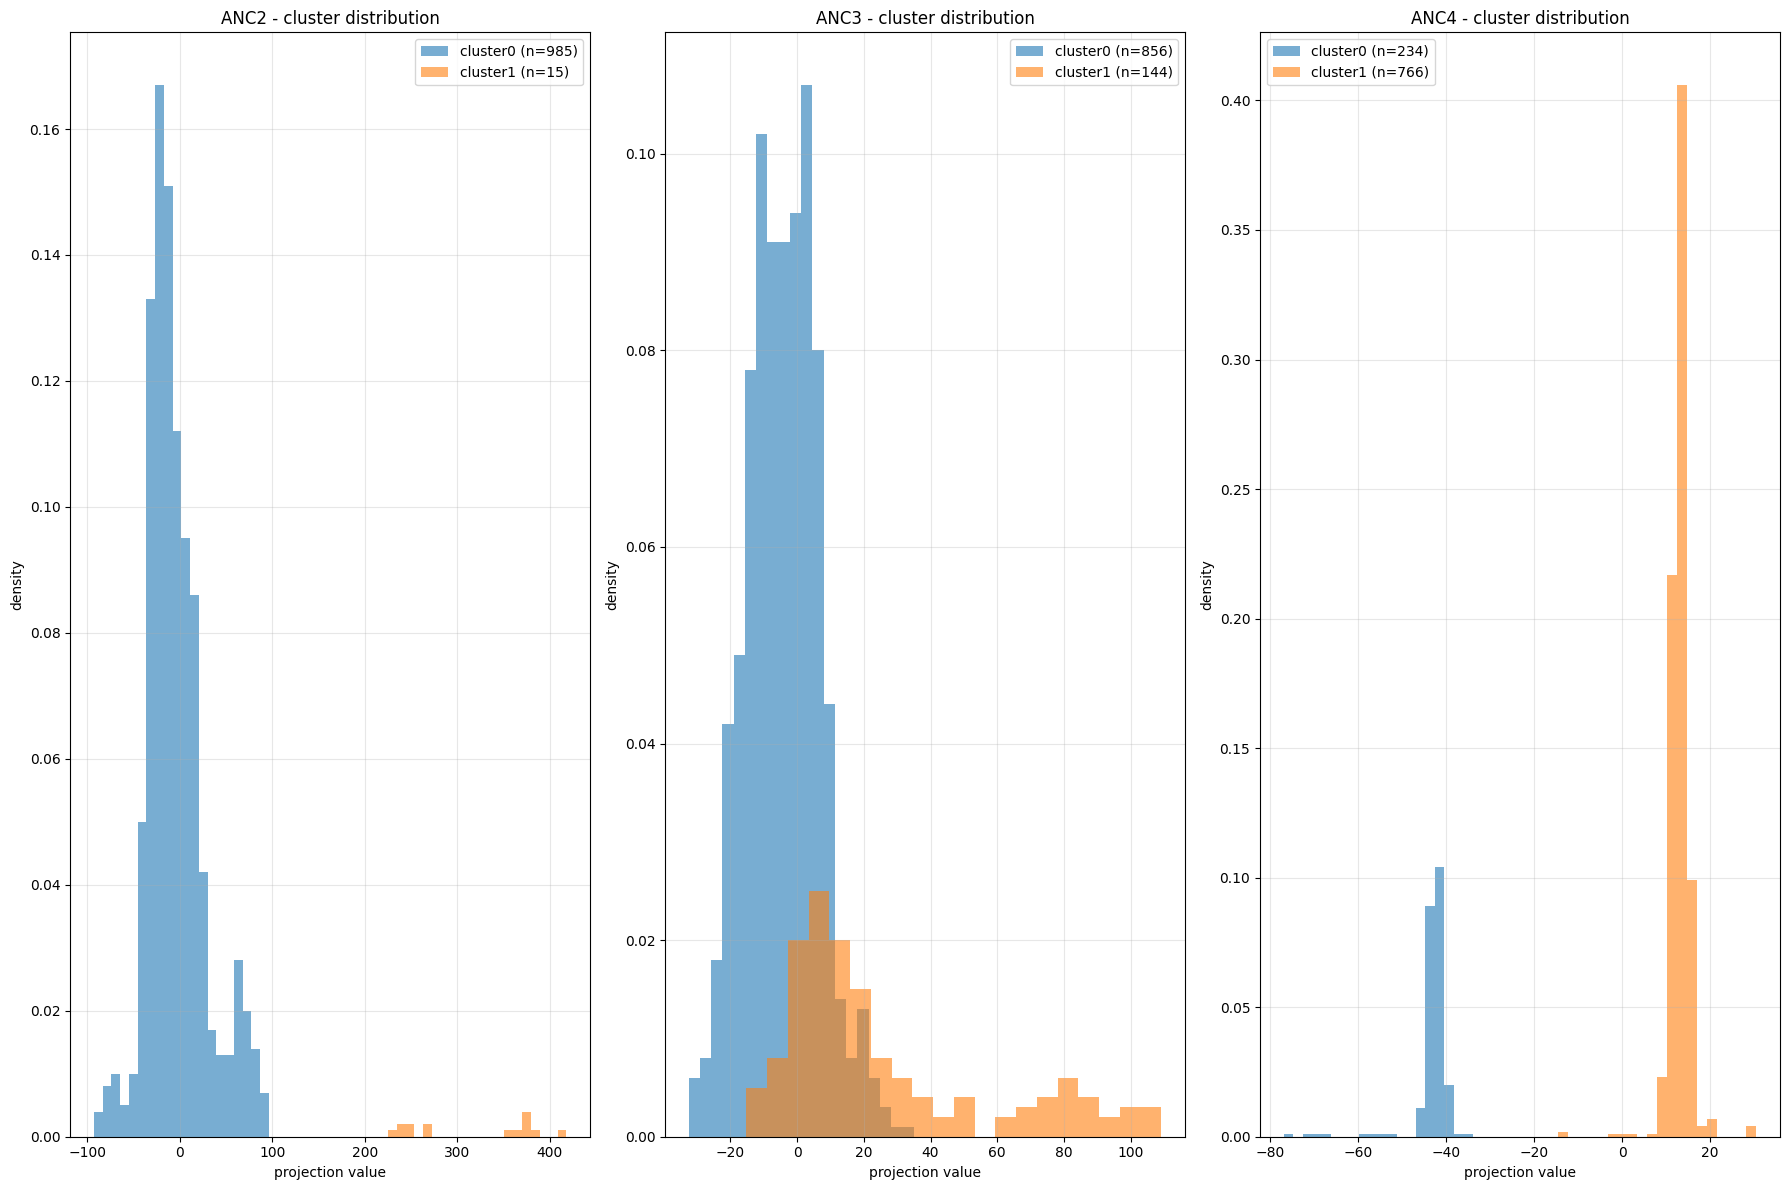

In [5]:
print("=== 初始化数据和模型 ===")

# 1. 获取关键接触点
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
new_contacts, lost_contacts = get_critical_contacts(chemokine_pdb, alternate_pdb,threshold=10.0,remove_diag=5)
critical_contacts = new_contacts + lost_contacts
print(f"关键接触点数量: {len(critical_contacts)}")

# 2. 加载MJ矩阵
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")

# 3. 生成contact embedding

contact_space = ContactSpace(critical_contacts, mj_dict)

# 批量添加节点
path_dir = "/yezhirui/evo_probe/data/sample"
node_configs = [("ANC0", f"{path_dir}/node499_anc0_samples.fasta"),("ANC1", f"{path_dir}/node500_anc1_samples.fasta"),
("ANC2", f"{path_dir}/node501_anc2_samples.fasta"), ("ANC3", f"{path_dir}/node502_anc3_samples.fasta"), ("ANC4", f"{path_dir}/node507_anc4_samples.fasta")]
for node_id, fasta_path in node_configs:
    contact_space.add_node_from_fasta(node_id, fasta_path)

contact_space.build_embeddings()

anc2_embedding = contact_space.get_node_embeddings("ANC2")
anc3_embedding = contact_space.get_node_embeddings("ANC3")
anc4_embedding = contact_space.get_node_embeddings("ANC4")

# 4. 进行GMM聚类分析
datasets = {
    'ANC2': anc2_embedding,
    'ANC3': anc3_embedding,
    'ANC4': anc4_embedding
}

all_results = compare_gmm_guided_projections(
    datasets,
    k=2,
)

anc2_results = all_results['ANC2']
anc3_results = all_results['ANC3']
anc4_results = all_results['ANC4']

In [6]:
# 5. 定义投影方向
v_target = anc3_results['projection_vector']
v_controls = generate_orthogonal_vectors(v_target, num_vectors=5)

print(f"v_target shape: {v_target.shape}")
print(f"v_controls数量: {len(v_controls)}")

# 6. 获取anc2_label1_sequences
anc2_sequences = contact_space.get_node_sequences("ANC2")


# anc2_label1_sequences = get_sequences_by_label(anc2_results['labels'], 1, anc2_sequences)
# anc2_labels = anc2_results['labels']
# label_1_mask = anc2_labels == 1
# label_1_embeddings = anc2_contact_embedding[label_1_mask]

# print(f"ANC2标签1的序列数量: {len(anc2_label1_sequences)}")

# 获取label 0的序列和对应的embedding
anc2_label0_mask = anc2_results['labels'] == 0
anc2_label0_sequences = [seq for seq, mask in zip(anc2_sequences, anc2_label0_mask) if mask]
anc2_label0_embeddings = anc2_embedding[anc2_label0_mask]

# 随机抽样15条序列
random_indices = np.random.choice(len(anc2_label0_sequences), size=15, replace=False)
anc2_label0_sequences_sampled = [anc2_label0_sequences[i] for i in random_indices]
anc2_label0_embeddings_sampled = anc2_label0_embeddings[random_indices]

print(f"ANC2标签0的序列总数: {len(anc2_label0_sequences)}")
print(f"随机抽样序列数量: {len(anc2_label0_sequences_sampled)}")

origin_seqs = anc2_label0_sequences_sampled
origin_embeddings = anc2_label0_embeddings_sampled



print("\n=== 开始突变体分析 ===")

# 7. 分析突变体投影


mutant_results = analyze_mutant_projections(
    origin_seqs,
    origin_embeddings,
    critical_contacts,
    mj_dict,
    contact_space.scaler,
    v_target,
    v_controls,
)

# 8. 统计分析
stats_results = statistical_analysis(mutant_results,len(v_controls))

print("\n=== 分析完成 ===")
print("结果总结:")
print(f"- 处理了 {len(origin_seqs)} 个原始序列")
print(f"- 生成了 {len(stats_results['target_projections'])} 个突变体")
print(f"- v_target方向平均绝对位移: {stats_results['target_stats']['abs_mean']:.4f}")

significant_controls = sum(1 for p in stats_results['p_values'] if p < 0.05)
print(f"- 显著高于控制方向的数量: {significant_controls}/{len(v_controls)}")

if significant_controls == len(v_controls):
    print("✓ 结论：突变体在v_target方向的位移显著高于所有控制方向")
elif significant_controls > 0:
    print(f"✓ 结论：突变体在v_target方向的位移显著高于{significant_controls}个控制方向")
else:
    print("✗ 结论：突变体在v_target方向的位移未显著高于控制方向")





v_target shape: (244,)
v_controls数量: 5
ANC2标签0的序列总数: 985
随机抽样序列数量: 15

=== 开始突变体分析 ===
处理序列 1/15
  生成 1330 个突变体
处理序列 2/15
  生成 1330 个突变体
处理序列 3/15
  生成 1330 个突变体
处理序列 4/15
  生成 1330 个突变体
处理序列 5/15
  生成 1330 个突变体
处理序列 6/15
  生成 1330 个突变体
处理序列 7/15
  生成 1330 个突变体
处理序列 8/15
  生成 1330 个突变体
处理序列 9/15
  生成 1330 个突变体
处理序列 10/15
  生成 1330 个突变体
处理序列 11/15
  生成 1330 个突变体
处理序列 12/15
  生成 1330 个突变体
处理序列 13/15
  生成 1330 个突变体
处理序列 14/15
  生成 1330 个突变体
处理序列 15/15
  生成 1330 个突变体

=== 统计分析结果 ===
总突变体数量: 19950

v_target方向:
  平均位移: -1.0606
  标准差: 7.5740
  绝对位移平均: 3.4480

v_control_0方向:
  平均位移: 0.1954
  标准差: 4.1951
  绝对位移平均: 1.3898

v_control_1方向:
  平均位移: 0.2283
  标准差: 7.8626
  绝对位移平均: 2.2200

v_control_2方向:
  平均位移: 0.2258
  标准差: 4.3043
  绝对位移平均: 1.3707

v_control_3方向:
  平均位移: 0.5927
  标准差: 4.7585
  绝对位移平均: 1.5213

v_control_4方向:
  平均位移: -0.0197
  标准差: 3.1980
  绝对位移平均: 1.2574

=== 显著性检验 ===
v_target vs v_control_0:
  统计量: 247888261.5
  p值: 0.00e+00
  显著性: 是 (α=0.05)
v_target vs v_control_1:
  统计量: 2555680

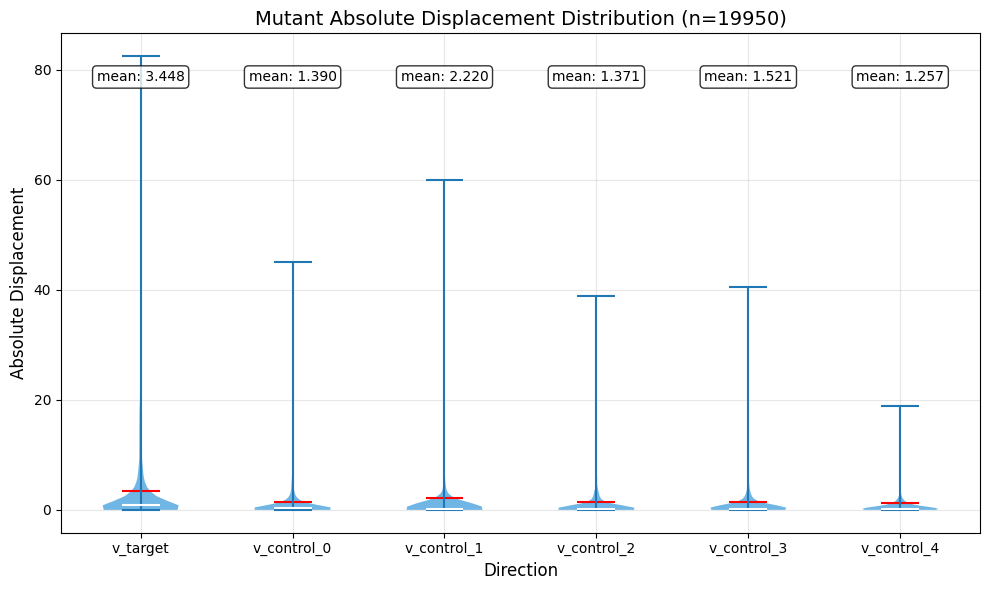

In [12]:
# 9. 可视化绝对位移分布
import matplotlib.pyplot as plt
import seaborn as sns

# 准备数据
target_abs = np.abs(stats_results['target_projections'])
control_0_abs = np.abs(stats_results['control_projections'][0])
control_1_abs = np.abs(stats_results['control_projections'][1]) 
control_2_abs = np.abs(stats_results['control_projections'][2])
control_3_abs = np.abs(stats_results['control_projections'][3])
control_4_abs = np.abs(stats_results['control_projections'][4])

# 创建小提琴图
plt.figure(figsize=(10, 6))
data_to_plot = [target_abs, control_0_abs, control_1_abs, control_2_abs, control_3_abs, control_4_abs]
labels = ['v_target', 'v_control_0', 'v_control_1', 'v_control_2', 'v_control_3', 'v_control_4']

# 使用seaborn绘制小提琴图
violin_parts = plt.violinplot(data_to_plot, showmeans=True, showmedians=True)

# 设置颜色
for pc in violin_parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.7)
violin_parts['cmeans'].set_color('red')
violin_parts['cmedians'].set_color('white')

plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Absolute Displacement', fontsize=12)
plt.xlabel('Direction', fontsize=12)
plt.title(f'Mutant Absolute Displacement Distribution (n={len(target_abs)})', fontsize=14)
plt.grid(True, alpha=0.3)

# 添加统计信息
for i, data in enumerate(data_to_plot):
    mean_val = np.mean(data)
    plt.text(i+1, plt.ylim()[1]*0.9, f'mean: {mean_val:.3f}',
             ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



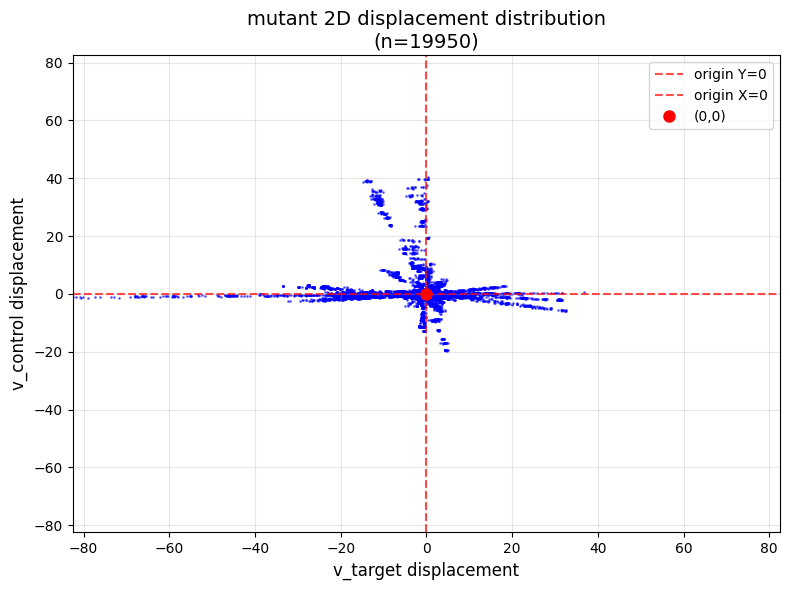


=== 二维分布统计 ===
v_target方向范围: [-82.518, 36.675]
v_control方向范围: [-19.624, 40.458]
v_target标准差: 7.574
v_control_0标准差: 4.759


In [17]:
# 10. 突变体位移散点图
import matplotlib.pyplot as plt

# 准备数据 - X轴：v_target方向位移，Y轴：v_control_0方向位移
x_data = stats_results['target_projections']  # v_target方向的位移
y_data = stats_results['control_projections'][3]  # v_control_0方向的位移

# 创建图形
plt.figure(figsize=(8, 6))

# 散点图
# 计算最大绝对值以设置相同的轴范围
max_abs = max(abs(max(x_data)), abs(min(x_data)), 
             abs(max(y_data)), abs(min(y_data)))
plt.scatter(x_data, y_data, alpha=0.5, s=1, c='blue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='origin Y=0')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='origin X=0')
plt.plot(0, 0, 'ro', markersize=8, label='(0,0)')
plt.xlabel('v_target displacement', fontsize=12)
plt.ylabel('v_control displacement', fontsize=12)
plt.title(f'mutant 2D displacement distribution\n(n={len(x_data)})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)

plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"\n=== 二维分布统计 ===")
print(f"v_target方向范围: [{x_data.min():.3f}, {x_data.max():.3f}]")
print(f"v_control方向范围: [{y_data.min():.3f}, {y_data.max():.3f}]")
print(f"v_target标准差: {np.std(x_data):.3f}")
print(f"v_control_0标准差: {np.std(y_data):.3f}")


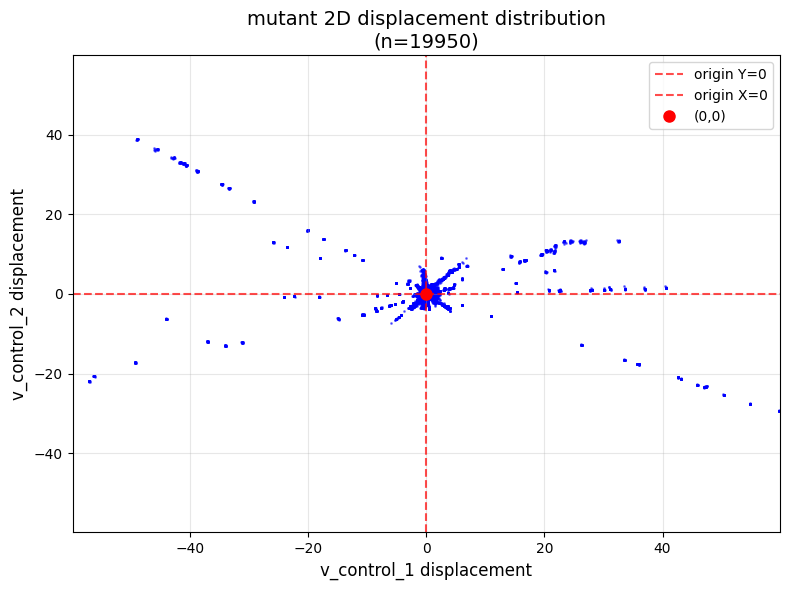


=== 二维分布统计 ===
v_target方向范围: [-57.173, 59.899]
v_control方向范围: [-29.456, 38.934]
v_target标准差: 7.863
v_control_0标准差: 4.304


In [22]:
# 10. 突变体位移散点图
import matplotlib.pyplot as plt

# 准备数据 - X轴：v_target方向位移，Y轴：v_control_0方向位移
x_data = stats_results['control_projections'][1]  # v_target方向的位移
y_data = stats_results['control_projections'][2]  # v_control_0方向的位移

# 创建图形
plt.figure(figsize=(8, 6))

# 散点图
# 计算最大绝对值以设置相同的轴范围
max_abs = max(abs(max(x_data)), abs(min(x_data)), 
             abs(max(y_data)), abs(min(y_data)))
plt.scatter(x_data, y_data, alpha=0.5, s=1, c='blue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='origin Y=0')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='origin X=0')
plt.plot(0, 0, 'ro', markersize=8, label='(0,0)')
plt.xlabel('v_control_1 displacement', fontsize=12)
plt.ylabel('v_control_2 displacement', fontsize=12)
plt.title(f'mutant 2D displacement distribution\n(n={len(x_data)})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)

plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"\n=== 二维分布统计 ===")
print(f"v_target方向范围: [{x_data.min():.3f}, {x_data.max():.3f}]")
print(f"v_control方向范围: [{y_data.min():.3f}, {y_data.max():.3f}]")
print(f"v_target标准差: {np.std(x_data):.3f}")
print(f"v_control_0标准差: {np.std(y_data):.3f}")
